# Homework 5 - The Marvel Universe!

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import deque
from collections import defaultdict
import random
import matplotlib.colors as mcolors

# 1. Data

In [2]:
df_hero_net = pd.read_csv("hero-network.csv")
df_edges = pd.read_csv("edges.csv")
df_nodes = pd.read_csv("nodes.csv")

In [ ]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [ ]:
df_hero_net.describe()

,hero1,hero2
count,574467,574467
unique,6211,6173
top,CAPTAIN AMERICA,CAPTAIN AMERICA
freq,8149,8350


In [ ]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [4]:
df_edges.describe()

,hero,comic
count,96104,96104
unique,6439,12651
top,SPIDER-MAN/PETER PARKER,COC 1
freq,1577,111


In [5]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [6]:
df_nodes.describe()

,node,type
count,19090,19090
unique,19090,2
top,2001 10,comic
freq,1,12651


In [7]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

In the dataframes obtained there are some hero names that do not match due to some *"typos"*. The goal of pre-processing is to arrange these "typos" in order to then be able to create the graphs **without inconsistencies**.

### 1.1.1 Extra spaces and extra '/'

At first, we **remove** extra spaces and extra '/' at the end of all the names in the dataframes. 

In [8]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [9]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_edges["comic"] = df_edges["comic"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [11]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [12]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [13]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


### 1.1.2 'SPIDER-MAN/PETER PARKER' typos

Then, we fix the 'SPIDER-MAN/PETER PARKER' typos in the datasets **replacing** the wrong names with the right one.

In [14]:
df_hero_net = df_hero_net.replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', regex=True)

In [15]:
df_nodes.node = df_nodes.node.replace('SPIDER-MAN/PETER PARKERKER','SPIDER-MAN/PETER PARKER', regex=True)

### 1.1.3 Drop self-loops


Some entries in *df_hero_net* dataframe have the same hero in both columns. In the graph, these entries form a self-loop: because a self-loop makes no sense in this network, we **remove** those from the dataset.

In [16]:
df_hero_net.shape

(574467, 2)

In [17]:
df_hero_net = df_hero_net[df_hero_net.hero1 != df_hero_net.hero2]
df_hero_net.shape

(572235, 2)

We remove 2232 rows/self-loops from *df_hero_net* dataframe.

### 1.1.4 Check of the pre-processing

At the end, we check if the typos are fixed and if there are other similar typos in the dataframes.

In [18]:
# check of hero names
hero_edges = set(df_edges.hero)
hero_heronet = set(df_hero_net.hero1).union(set(df_hero_net.hero2))
hero_nodes = set(df_nodes.loc[df_nodes.type=='hero']['node'])

# hero names differences between df_edges and df_hero_net 
print(hero_edges - hero_heronet)
print(hero_heronet - hero_edges)

{'BLARE', 'SHARKSKIN', 'JOHNSON, LYNDON BAIN', 'FENRIS', 'CLUMSY FOULUP', 'RANDAK', 'RUNE', 'CALLAHAN, DANNY', 'DEATHCHARGE', 'MARVEL BOY II/MARTIN', 'KULL', 'RED WOLF II', 'GERVASE, LADY ALYSSA', 'GIURESCU, RADU', 'ZANTOR', 'BERSERKER II', 'SEA LEOPARD', 'LUNATIK II'}
set()


In [19]:
# hero names differences between df_edges and df_nodes 
print(hero_edges - hero_nodes)
print(hero_nodes - hero_edges)

set()
set()


In [20]:
# hero names differences between df_hero_net and df_nodes 
print(hero_nodes - hero_heronet)
print(hero_heronet - hero_nodes)

{'BLARE', 'SHARKSKIN', 'JOHNSON, LYNDON BAIN', 'FENRIS', 'CLUMSY FOULUP', 'RANDAK', 'RUNE', 'CALLAHAN, DANNY', 'DEATHCHARGE', 'MARVEL BOY II/MARTIN', 'KULL', 'RED WOLF II', 'GERVASE, LADY ALYSSA', 'GIURESCU, RADU', 'ZANTOR', 'BERSERKER II', 'SEA LEOPARD', 'LUNATIK II'}
set()


In [21]:
# check the comic names
comic_edges = set(df_edges.comic)
comic_nodes = set(df_nodes.loc[df_nodes.type=='comic']['node'])

In [22]:
# comic names differences between df_edges and df_nodes 
print(comic_edges-comic_nodes)
print(comic_nodes-comic_edges)

set()
set()


We notice that some hero names are the same as comic names. We therefore decide to add word 'comic' at the end to the comic names equal to those of the heroes, in order to avoid problems in the creation and management of graphs.

In [23]:
equals = hero_edges.intersection(comic_edges)
equals

{'BLADE', 'REBEL', 'SABRE'}

In [24]:
hero_nodes.intersection(comic_nodes)

{'BLADE', 'REBEL', 'SABRE'}

In [25]:
for i in equals:
    df_edges.comic = df_edges.comic.replace(i, i+' comic', regex=True)




## 1.2 First graph

We create this graph using the *df_hero_net* dataframe, in which an edge between two heroes can be found if they have appeared in the same comic together. The graph is **weighted** and **undirected**.

The **number of edges** between two heroes represents the number of times they have collaborated in different comics and we can use it as **metric** to calculate the weight of each edge.

In [26]:
G1 = nx.MultiGraph()

In [27]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 572235, dtype: int64

In [28]:
# check again sefl-loops

nx.number_of_selfloops(G1)

0

In [29]:
# preview of the edge structure of first graph 
list(G1.edges())[:10]

[('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL")]

We decide to use a dictionary to keep the **number of occurrences** of each edge.

In [30]:
numberOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in numberOfOccurances:
            numberOfOccurances[(h1,h2)] += 1
        else:
            numberOfOccurances[(h1,h2)] = 1

We then define the weight of each edge x as:

$ weight(x) = {1 \over numberOfOccurances(x)} $

In this way the heroes with **more collaborations** will have a **lower weight**. This is because there will be more "ways" to get from one node to another, so those paths will have to be less relevant than those that instead have only one way to get there.

In [31]:
G1_weighted = nx.MultiGraph()

In [33]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/numberOfOccurances[edge], 3))
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/numberOfOccurances[(edge[1], edge[0])],3))


Oonce the weights have been set for each edge, we can transform the multigraph into a graph; in fact, the information on the number of edges is maintained through the weight of the edge itself.

An edge with weight **less than 1** corresponds to several edges in the original multigraph, one with **weight 1** corresponds to a unique edge in the original multigraph.

In [34]:
G1_weighted_graph = nx.Graph(G1_weighted)

In [35]:
# preview of the weighted edges structure of first graph
edges, weights = zip(*nx.get_edge_attributes(G1_weighted_graph, 'weight').items())
for i in range(10):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)


We also create a dictionary of the weights of each edge to avoid navigating the all graph each time to get this information.

In [37]:
dicOfWeights = {}
for edge in G1_weighted_graph.edges():
    dicOfWeights[edge] = G1_weighted_graph.get_edge_data(edge[0], edge[1])['weight']

## 1.3 Second graph

We create this graph using *df_edges* dataframe. The graph will have as nodes the names of all the comics and the heros in the dataframe. All the edges will be between a comic node and a hero node and we will put an edge between an hero and a comic whenever that hero has appeared in that comic. The graph is **undirected** and **unweighted**.

Let's start storing a dictionary ***attributes*** in which we store the type of every node.

In [38]:
attributes = {}
for elem in df_edges['hero']:
    attributes[elem] = {'type' : 'hero' } 
for elem in df_edges['comic']:
    attributes[elem] = {'type' : 'comic' } 

print('Number of elements in attributes list: ' + str(len(attributes)))

Number of elements in attributes list: 19090



We now create the second graph using *df_edges* and then we set as nodes attributes the type of the node (comic or hero). 

In [39]:
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)
print('Number of nodes of the second graph: ' + str(len(G2.nodes())))
print('Number of edges of the second graph: ' +  str(len(G2.edges())))

Number of nodes of the second graph: 19090
Number of edges of the second graph: 96104


Have a look at some of the nodes and their corresponding attributes.

In [40]:
nodes, types = zip(*nx.get_node_attributes(G2, 'type').items())
for i in range(10):
    print(nodes[i], types[i])

24-HOUR MAN/EMMANUEL hero
AA2 35 comic
3-D MAN/CHARLES CHAN hero
AVF 4 comic
AVF 5 comic
COC 1 comic
H2 251 comic
H2 252 comic
M/PRM 35 comic
M/PRM 36 comic


## 1.4 TopN

The next 2 functions will be used in the functionalities in order to select subgraph of the original ones using as heros only the top N.

In [41]:
def create_G1_topN(N, df):
    G_topN = G1_weighted_graph.copy()
    most_popular_heros = df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)
    notInTopN = set(G1_weighted_graph.nodes()) - set(most_popular_heros.index)
    G_topN.remove_nodes_from(notInTopN)
    return G_topN

In [42]:
def create_G2_topN(N, df):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count").sort_values(by = 'count',ascending=False).head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G2.subgraph(new_nodes)
    return G_top_N

An example of how the two graphs change considering the top 10 heroes:

In [43]:
G1_topN = create_G1_topN(10, df_edges)
print("Number of nodes in G1:",  len(G1_weighted_graph.nodes()))
print("Number of nodes in G1_topN:",  len(G1_topN.nodes()))
print(" ")
print("Number of edges in G1:", len(G1_weighted_graph.edges()))
print("Number of edges in G1_topN:", len(G1_topN.edges()))


Number of nodes in G1: 6421
Number of nodes in G1_topN: 10
 
Number of edges in G1: 167100
Number of edges in G1_topN: 45


In [44]:
G2_topN= create_G2_topN(10, df_edges)
print("Number of nodes in G1:",  len(G2.nodes()))
print("Number of nodes in G1_topN:",  len(G2_topN.nodes()))
print(" ")
print("Number of edges in G1:", len(G2.edges()))
print("Number of edges in G1_topN:", len(G2_topN.edges()))

Number of nodes in G1: 19090
Number of nodes in G1_topN: 6059
 
Number of edges in G1: 96104
Number of edges in G1_topN: 10136


# 2. Backend Implementation

We decide to put some **auxiliary functions** used for backend implementation in a separate file, *functions.py*, and we import it.

In [45]:
# importing functions
import functions

## Functionality 1 - extract the graph's features

In [46]:
def functionality_1(G, G_type, N):
    if G_type == 1:
        G1_topN = create_G1_topN(N, df_edges)
        
        # number of nodes in the network
        n_nodes_G1_topN = int(G1_topN.number_of_nodes())
        
        # number of collaborations of each superhero with the others
        degree_G1_topN = G1_topN.degree()
        sorted_degree_G1_topN = sorted(degree_G1_topN, key=lambda x: x[1], reverse=True)
    
        # network's density
        density_G1_topN = len(G1_topN.edges())/(n_nodes_G1_topN*(n_nodes_G1_topN-1)/2)

        # network's degree distribution
        degree_dist_G1_topN = functions.degree_distG(G1_topN) 

        #  average degree of the network
        degree_sequence_G1_topN = sorted([deg for i, deg in G1_topN.degree()], reverse=True)
        avg_degree_G1_topN = sum(degree_sequence_G1_topN) / len(degree_sequence_G1_topN)

        # network's Hubs
        hubs_G1_topN = sorted(functions.hubs_G1(G1_topN), key=lambda x: G1_topN.degree(x), reverse=True)

        # whether the Network is sparse or dense
        type_graph_G1_topN = ""    
        if functions.density_G(G) >= 0.5:
            type_graph_G1_topN = "DENSE"
        else:
            type_graph_G1_topN = "SPARSE"
    
        return n_nodes_G1_topN, sorted_degree_G1_topN, density_G1_topN, degree_dist_G1_topN, avg_degree_G1_topN, hubs_G1_topN, type_graph_G1_topN


    elif G_type == 2:
        G2_topN = create_G2_topN(N, df_edges)
        
        # number of nodes in the network
        count_hero = 0
        count_comic = 0
        nodes, types = zip(*nx.get_node_attributes(G2_topN, 'type').items())
        for elements in types:
            if elements == 'hero':
                count_hero += 1
            elif elements == 'comic':
                count_comic += 1

        # number of heroes that have appeared in each comic
        hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
    
        # network's density
        density_G2_topN = len(G2_topN.edges())/(count_hero*(count_hero-1)/2)

        # network's degree distribution
        degree_dist_G2_topN = functions.degree_distG(G2_topN)
        
        # average degree of the network
        degree_sequence_G2_topN = sorted([deg for i, deg in G2_topN.degree()], reverse=True)
        avg_degree_G2_topN = sum(degree_sequence_G2_topN) / len(degree_sequence_G2_topN)
        
        # network's Hubs
        hubs_G2_topN = sorted(functions.hubs_G2(G2_topN), key=lambda x: G2_topN.degree(x), reverse=True)

        # whether the Network is sparse or dense
        type_graphG2 = ""    
        if functions.density_G(G) >= 0.5:
            type_graphG2 = "DENSE"
        else:
            type_graphG2 = "SPARSE"
 

        return (count_hero, count_comic), hero_appeard, density_G2_topN, degree_dist_G2_topN, avg_degree_G2_topN, hubs_G2_topN, type_graphG2  
    
    else:
        return "Graph type not valid."

## Functionality 2 - Find top superheroes!

The concept of centrality is used to determine the most important node in a network, whose main characteristics are its ability to communicate directly with other nodes:
- The degree of simple centrality measures the ability of a node to communicate directly with all nodes;
- The closeness centrality of a node indicates how close it is to other nodes in the network, and is measured in terms of the shortest path;
- Betweenness centrality indicates how important a node is in communication between different parts of the network;
- Pagerank is based on the concept of links: several important pages refer (through a link) to one page,the more the page itself will be important. Somehow the definition is recursive. is a number that represents the importance of a page. The higher the number the more likely it is the page is relevant in general.

In [47]:
def functionality_2(G, node, metric, N):
    if node in G.nodes():
        G = create_G1_topN(N, df_edges)
    else:
        G = create_G2_topN(N, df_edges)

    if metric == "betweenness":
        graph_value = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index', columns=['betweenness']).sort_values(by='betweenness', ascending=False)
        node_value = graph_value[graph_value.index == node]

    elif metric == "degree":
        graph_value = pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index', columns=['degree']).sort_values(by='degree', ascending=False)
        node_value = graph_value[graph_value.index == node]

    elif metric == "pagerank":
        graph_value = pd.DataFrame.from_dict(nx.pagerank(G), orient='index', columns=['pagerank']).sort_values(by='pagerank', ascending=False)
        node_value = graph_value[graph_value.index == node]

    elif metric == "closeness":
        graph_value = pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index', columns=['closeness']).sort_values(by='closeness', ascending=False)
        node_value = graph_value[graph_value.index == node]
        
    else:
        return 'Metric not valid.'
        
    return metric, graph_value, node_value 

## Functionality 3 - Shortest ordered Route

This function takes as input the second graph, an integer $N$, two heros $h_1$, $h_n$ and a list of heros $h=[h_2,...h_{n-1}]$.  
Given this input the *functionality_3* computes the shortest path of comics between $h_1$ and $h_2$ visiting in order the heros in $h$.  

In order to do this we first select a subgraph of the original one such that contains only 'hero' nodes that correspond to the top N using the function *create_G2_topN* and then we iteratively look for the shortest path between $h_i$ and $h_{i+1}$ with $i\in \{1,...,n-1\}$ using the function *shortest_path_two_nodes* that you can find in the file ***functions.py***. 

Since we want to visit in the given order the heros in $h$ when we're looking for the shortest path between $h_i$ and $h_{i+1}$ we work with a subgraph of the topN one that contains all the nodes of the original one except for the heros of $h$ that are different from $h_i$ and $h_{i+1}$.   

At the end of this process we'll have the shortest path between *h_1* and *h_n* with the requested conditions. Of course the *shortest_path* computed will contain 'comic' nodes but also 'hero' nodes, since we have edges only between 'comic' and 'hero' nodes, so during the *visualization_3* we'll print only the shortest path of comics.


In [48]:
def functionality_3(G2, N, h_1, h_n, h):
    if N:
        N = int(N)
        G2_top_N = create_G2_topN(N, df_edges)
    att = nx.get_node_attributes(G2_top_N, "type")
    if h_1  not in list(G2_top_N.nodes) or h_n not in list(G2_top_N.nodes):
        return [], G2_top_N
    shortest_path = np.array([h_1])
    s = h_1
    for t in h:
        app = functions.shortest_path_two_nodes(s,t,G2_top_N,[h_1]+h+[h_n])
        if app == []:
            return [], G2_top_N
        s = t
        app = np.array(app)
        shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    app = list(nx.shortest_path(G2_top_N, source=t, target=h_n, weight=None))
    app = np.array(app)
    shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    
    return shortest_path, G2_top_N

## Functionality 4 - Disconnecting Graphs

The goal of functionality 4 is to disconnect the original graph G into two subgraphs *G_a* and *G_b*. 
The two subgraphs are generated by two heroes passed as parameters: *heroA* generates G_a, while *heroB* generates G_b. The parameter N represents how many of the top N heroes we eant to consider (N can also coincide with all heroes).

The idea behind the algorithm is to compute each time the **shortest weighted path** between the two heroes, heroA and heroB, and to remove the edge with **greater weight**. 

We remove those of greater weight because the metric we use to weight the edges makes the edges with the greatest weight coincide with those that in the original multigraph have fewer paths or a single path (weigh == 1) between the two heros. Therefore they represent a **fundamental path** between the two heros which, if removed, have no other alternative path or less paths than in the case of the edges with less weight .

We use the function *search_shortest_path*, contained in the *functions.py* file, in order to calculate the shortest weighted paths through **Dijkstra's algorithm**.

The algorithm ends when there are *no more shortest weighted path* between the two heroes: this means that they are **disconnected**.


In [49]:
def functionality_4(G, N, heroA, heroB):
    count = 0
    G_topN = create_G1_topN(N, df_edges)

    while functions.search_shortest_weighted_path(G_topN, heroA, heroB) != 0:
        shortest_path = functions.search_shortest_weighted_path(G_topN, heroA, heroB)
        dic = {}
        for i in range(len(shortest_path)-1):
            weight = G.get_edge_data(shortest_path[i], shortest_path[i+1])['weight']
            dic[(shortest_path[i],shortest_path[i+1])] = weight
        
        dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))  

        # as long as there is a shortest weighted path, we remove the edge with the greatest weight
        G_topN.remove_edge(list(dic.keys())[0][0], list(dic.keys())[0][1])
        count+=1
    
    # create a list of colors in order to identify the nodes that correspond to heroA and heroB with red color
    colors = ['red' if node == heroA or node == heroB else 'blue' 
                for node in G_topN.nodes()]
                
    return G_topN, count, colors

## Functionality 5 - Extracting Communities

This function takes as input the first graph, an integer $N$ and two heros $Hero\_1$ and $Hero\_2$. 

Given this input the *functionality_5* computes the minimum number of edges that must be removed in order to form comunities.   

In order to do this we first select a subgraph of the original one such that contains only the top N heros using the function *create_G1_topN* and then we use the Girvan-Newman algorithm that is explained in the suggested link. 

The main idea of the Girvan-Newman algorithm is to remove iteratively edges that have higher edge betweeness centrality until the graph is disconnected in comunities. This because comunities are defined as groups of nodes that are strongly connected between each other and loosely connected with the other comunities so if between comunities there are few edges these edges should have higher EBC.   

In the *functionality_5* after computing the graph $G\_top\_N$ we'll iteratively compute EBC of all the edges and we'll drop the edge with maximum EBC value until we obtain disconnected components.   
After that we'll check if $Hero_1$ and $Hero_2$ are in the same comunity.


In [50]:
def functionality_5(G1,N, Hero_1, Hero_2):
    G_top_N = create_G1_topN(N, df_edges)
    G = nx.Graph(G_top_N)
    
    num_components = nx.number_connected_components(G)
    edges_to_remove = 0
    while True:
        if num_components > 1:
                break
        G_dict = {}
        G_dict = nx.edge_betweenness_centrality(G)
        max_EBC = max(G_dict.values())
        edges = []
        for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
            edges.append(key)
            break
        edges_to_remove += len(edges)
        G.remove_edge(edges[0][0],edges[0][1])
        num_components = nx.number_connected_components(G)    
    
    hero_1_2_together = False
    comunities = []
    for comunity in nx.connected_components(G):
        comunities.append(list(comunity))
        if Hero_1 in comunity and Hero_2 in comunity:
            hero_1_2_together = True
    

    return edges_to_remove, G, comunities, hero_1_2_together, G_top_N

# 3. Frontend Implementationc

In this section, we build the visualizations for users' query results in order to improve understanding of what each funcionality does through the use of tables and plots.

## Visualization 1 - Visualize some features of the network

In [51]:
def visualization_func1(G_type, n_nodes, collaborations, density, degree_dist, avg_degree, hubs, type_graph):
    if G_type == 1:
        general_info_G1 = {
                "Number of nodes": n_nodes,
                "Density": density,
                "Average degree": avg_degree,
                "Netowrk type" : type_graph,
                }
        # general info of G1
        print("General info of G1:")
        df_general_info_G1 = pd.DataFrame(general_info_G1, index=[0])
        print(df_general_info_G1)
        
        # hubs of G1
        df_hubs = pd.DataFrame(hubs, columns=['Hubs'])
        print("Plot of hubs table of G1:")
        print(df_hubs)
        
        # number of collaborations of each hero
        plt.figure(figsize=(10,10))
        plt.bar(*zip(*collaborations))
        plt.title("Number of collaborations of each hero in descending order of G1")
        plt.xlabel("Hero")
        plt.ylabel("Number of collaborations")
        plt.xticks(rotation=90)
        plt.show()

        # degree distribution of the network
        plt.figure(figsize=(10,5))
        plt.hist(degree_dist, bins=50)
        plt.xlabel('Degree')
        plt.ylabel('Number of nodes')
        plt.show()

    else:
        general_info_G2 = {
                "Number of hero nodes": n_nodes[0],
                "Number of comic nodes": n_nodes[1],
                "Density": density,
                "Average degree": avg_degree,
                "Netowrk type" : type_graph,
                }

        # General info of G2 as a table with pandas
        df_general_info_G2 = pd.DataFrame(general_info_G2, index = [0])
        print("General info of G2:")
        print(df_general_info_G2)


        # hubs table
        df_hubs = pd.DataFrame(hubs, columns=['Hubs'])
        print("Plot of the hubs table of G2:")
        print(df_hubs)

        #number of heroes who appeared in each comic
        plt.figure(figsize=(10,5))
        
        plt.hist(collaborations['hero'], bins=100)
        plt.xlabel('Number of heroes')
        plt.ylabel('Number of comics')
        plt.show()

        # degree distribution of the network
        plt.figure(figsize=(10,5))
        plt.hist(degree_dist, bins=50)
        plt.xlabel('Degree')
        plt.ylabel('Number of nodes')
        plt.show()

    return


## Visualization 2 - Visualize centrality measure

In [52]:
def visualization_func2(metric, graph_value, node_value):
    
    graph_avg = graph_value[metric].mean()
    print(graph_value)
    print("The average of the requested centrality measure for all of the network's nodes is: ", graph_avg)
    print("The given node's value is: ", float(node_value[metric]))
    return 

## Visualization 3 - Visualize the shortest-ordered route

As requested the next function *visualization_3* given as imput the results of the *functionality_3* will print the comics in the shortest walk in order and plot the graph identifying the nodes and edges that appear in the shortest walk.

In [53]:
def visualization_3(shortest_path, G2_top_N):
    
    print(' ')
    
    if len(shortest_path)==0:
        print('There is not such path!')
        return
    
    # print the shortest walk with comics and heros
    print('This is the shortest path including all the nodes (heros and comics) that have been visited:')
    print(shortest_path)
    
    print(' ')
    
    # print the shortest walk of comics
    print('This is the shortest path of comics in order starting from the hero', shortest_path[0],'to the hero', shortest_path[-1],':')
    shortest_comic = [i for i in shortest_path if i in df_edges.comic.to_numpy()]
    path = shortest_comic[0]
    for i in shortest_comic:
        path = path + ' -> ' + i
    print(path)
    
    print(' ')
    
    # plot the graph identifying the nodes and edges in the shortest walk
    print('In the following graph you will see the nodes in the shortest path in red and you can see the order of the visit in the number written above the edges.')
    size = []
    map_color = []
    labels = {}

    att = nx.get_node_attributes(G2_top_N,'type')
    for node in G2_top_N:
        if node in shortest_path:
            if att[node] == 'comic':
                size.append(800)
                labels[node] = 'comic: '+node
            else:
                size.append(200)
                labels[node] = 'hero: '+node
            map_color.append('red')
        else:
            size.append(100)
            map_color.append('black')

    edge_list =[]
    edge_labels = {}
    for i in range(len(shortest_path)-1):
        if (shortest_path[i],shortest_path[i+1]) in edge_labels.keys():
            print((shortest_path[i],shortest_path[i+1]))
            edge_labels[(shortest_path[i],shortest_path[i+1])] = edge_labels[(shortest_path[i],shortest_path[i+1])] + ',' + str(i+1)
        elif (shortest_path[i+1],shortest_path[i]) in edge_labels.keys():
            edge_labels[(shortest_path[i+1],shortest_path[i])] = edge_labels[(shortest_path[i+1],shortest_path[i])] + ',' + str(i+1)
        else:
            edge_labels[(shortest_path[i],shortest_path[i+1])] = str(i+1)
            edge_list.append((shortest_path[i],shortest_path[i+1]))        
    plt.figure(3,figsize=(12,12))
    pos = nx.spring_layout(G2_top_N, seed=7)
    nx.draw(G2_top_N, pos, node_color=map_color, node_size = size, with_labels=False,width=0.5,font_size=8)
    nx.draw_networkx_labels(G2_top_N,pos,labels,font_size=12,font_color='g')
    nx.draw_networkx_edge_labels(G2_top_N,pos,edge_labels=edge_labels,font_color='r', font_size= 12)
    nx.draw_networkx_edges(
        G2_top_N,
        pos = pos,
        edgelist=edge_list,
        width=5,
        alpha=0.5,
        edge_color="tab:red",
    )
    plt.show()    
    
    
    # plot only the shortest path
    print('Since the graph above contains a lot of nodes the following plot contains only the nodes of the shortest path.')
    path = G2_top_N.subgraph(shortest_path)
    plt.figure(3,figsize=(8,8))
    pos = nx.spring_layout(path, seed=7)
    nx.draw(path, pos, node_color='r', node_size = 1000, with_labels=False ,width=0.5,font_size=8)
    nx.draw_networkx_labels(path,pos,labels,font_size=12,font_color='b')
    nx.draw_networkx_edge_labels(path,pos,edge_labels=edge_labels,font_color='r', font_size= 12)
    plt.show()
    return

## Visualization 4 - Visualize the disconnected graph


As requested the next function *visualization_4* given as imput the results of the *functionality_4* will print the  the number of the links that should be disconnected and will plot the original graph and the graph after removing the links and identify the two nodes.

In [54]:
def visualization_func4(G_topN, G_disconnected, minNumLinks, colors):

    print('The minimum number of links required to disconnect the original graph into two disconnected subgraphs is: ' + str(minNumLinks))
    
    print("Plot of the original graph: ")
    fig = plt.figure(figsize=(18,18))
    pos = nx.spring_layout(G_topN, seed=7)  # positions for all nodes - seed for reproducibility
    edge_labels = nx.get_edge_attributes(G_topN, "weight")
    nx.draw(G_topN, pos = pos, with_labels=True, node_size=300)
    nx.draw_networkx_edge_labels(G_topN, pos = pos, edge_labels = edge_labels)
    plt.show()

    print("Plot of the graph after removing the links and identify the two nodes: ")
    fig = plt.figure(figsize=(18,18))
    pos = nx.spring_layout(G_disconnected, seed=7)  # positions for all nodes - seed for reproducibility
    edge_labels = nx.get_edge_attributes(G_disconnected, "weight")
    nx.draw(G_disconnected, pos = pos, node_color = colors, with_labels=True, node_size=300)
    nx.draw_networkx_edge_labels(G_disconnected, pos = pos, edge_labels = edge_labels)
    plt.show()
    
    return

# Visualization 5 - Visualize the communities

As requested the next function *visualization_5* given as input the results of *functionality_5* will print the number of links that should be removed to have the communities, print the communities and the heroes that belong to each community, plot the original graph, plot the graph showing the communities in the network and plot the final graph identifiyng the community/communities of Hero_1 and Hero_2.

In [55]:
def visualitazion_5(number_of_edges,G,comunities,hero_1_2,original_G,Hero_1,Hero_2):
    
    print(' ')
    
    # print the number of links
    print('The number of links that should be removed to have the communities is: ', number_of_edges)
    
    print(' ')
    
    # print heros of each comunity
    for i in range(len(comunities)):
        print('The components of the',i+1,'-th comunity are:')
        print(comunities[i])
        print(' ')
    
    print(' ')
    
    # plot the original top_N graph
    print('The original graph of the top N heros is:')
    plt.figure(3,figsize=(12,12))
    pos = nx.spring_layout(original_G, seed=7)
    nx.draw(original_G, pos = pos, with_labels = True,width=0.5, font_size=8)
    plt.show()
    
    # plot the graph showing the comunities in the network
    print('The final graph divided in comunities, all of them in different colors, is:')
    color=list(mcolors.CSS4_COLORS.keys())
    color_map = []
    for node in G:
        for i in range(len(comunities)):
            if node in comunities[i]:
                color_map.append(color[i])
                break
    plt.figure(3,figsize=(12,12))
    pos = nx.spring_layout(G, seed=7)
    nx.draw(G, node_color=color_map, with_labels=True, width = 0.5, font_size=8)
    plt.show()
    
    # plot the final graph identifying the community/communities of Hero_1 and Hero_2
    if hero_1_2:
        print(Hero_1,'and',Hero_2,'are in the same comunity')
    else:
        print(Hero_1,'and',Hero_2,'are not in the same comunity')
    
    nodes = set()
    color_map = []
    size = []
    for i in range(len(comunities)):
            if Hero_1 in comunities[i] and Hero_2 in comunities[i]:
                index=i
                for node in comunities[i]:
                    nodes.add(node)
            else:
                if Hero_2 in comunities[i]:
                    index_2 = i
                    for node in comunities[i]:
                        nodes.add(node)
                elif Hero_1 in comunities[i]:
                    index_1 = i
                    for node in comunities[i]:
                        nodes.add(node)
    G_heros = G.subgraph(nodes)
    if hero_1_2:
        for node in G_heros.nodes:
            if node == Hero_1 or node == Hero_2:
                size.append(1000)
            else:
                size.append(200)
            color_map.append('darkmagenta')
    else:
        for node in G_heros.nodes:
            if node in comunities[index_1]:
                color_map.append('darkmagenta')
                if node == Hero_1:
                    size.append(1000)
                else:
                    size.append(200)
            if node in comunities[index_2]:
                color_map.append('green')
                if node == Hero_2:
                    size.append(1000)
                else:
                    size.append(200)

    plt.figure(3,figsize=(12,12))
    pos = nx.spring_layout(G_heros, seed=7)
    nx.draw(G_heros, node_color=color_map, node_size = size, with_labels=True,width=0.5,font_size=8)
    plt.show()
    
    return

# Controller System

The goal of this part is the implementation of a controller system which makes the user interact with the features created.

The controller system takes as input an identifier "i" and some parameters and run the associated function_i, passing the selected parameters as input.

In order to improve visualization and execution time, we give the user the possibility to choose the number of top N heroes to consider. If he presses 0, he decides to consider all the nodes present in the graph.

We also use *try/except* structure to handle any errors in choosing the parameters to pass as input to the features.

In [58]:
def controller_system():

    chosen_func = int(input("Select your functionality (from 1 to 5): "))

    if (chosen_func == 1):
        print("You have chosen functionality 1 which extract the graph's features.")
        G_type = int(input("Insert the type of graph you want to analyze: "))
        print("You have chosen to analyze the graph of type " + str(G_type) + ".")
        N = int(input("Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: "))
        if N == 0:
            print("You have chosen to consider all the nodes of the graph.")
            if G_type == 1:
                n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G1_weighted_graph, G_type, len(G1_weighted_graph.nodes()))
                visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)
            elif G_type == 2:
                n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G2, G_type, len(G2.nodes()))
                visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)
            else:
                return "Invalid type."
        else:
            print("You have chosen to consider the top " + str(N) + " heroes.")
            if G_type == 1:
                n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G1_weighted_graph, G_type, N)
                visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)
            elif G_type == 2:
                n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G2, G_type, N)
                visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)
            else:
                return "Invalid type."

    elif (chosen_func == 2):
        node = str(input("Insert the node you want to analyze: "))
        print("You have chosen to analyze the node " + str(node) + ".")
        N = int(input("Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: "))
        if N == 0:
            print("You have chosen to consider all the nodes of the graph.")
            if node in G1_weighted_graph.nodes():
                G = G1_weighted_graph
                N = len(G.nodes())
            elif node in G2.nodes():
                G = G2
                N = len(G.nodes())
            else:
                return "Invalid node."
            
        else:
            print("You have chosen to consider the top " + str(N) + " heroes.")
            if node in G1_weighted_graph.nodes():
                G = create_G1_topN(N, df_edges)
            elif node in G2.nodes():
                G = create_G2_topN(N, df_edges)
            else:
                return "Invalid node."

        metric = str(input("Insert the metric you want to use: "))
        print("You have chosen to use the metric " + str(metric) + ".")
        
        metric, graph_value, node_value = functionality_2(G, node, metric, N)
        visualization_func2(metric, graph_value, node_value)  

    elif (chosen_func == 3):
        print("You have chosen functionality 3 which computes the shortest path of comics between two given heros.")
        N = int(input("Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: "))
        
        if N == 0:
            N = len(G2.nodes())
            print("You have chosen to consider all the nodes of the graph.")
        else:
            print("You have chosen to consider the top " + str(N) + " heroes.")

        heroA = str(input('Insert the hero from which the path should start: '))
        print("The hero from which the path will start is: " + heroA)
        heroB = str(input('Insert the hero in which the path should end: '))
        print("The hero in which the path will end is: " + heroB)
        n = int(input("Insert the number of heros that you want to visit during the path: "))
        heros = []
        for i in range(n):
            print('Insert the',i+1,'-th hero:')
            heros.append(input())
        print('During the path you have chosen to visit the following heros:', heros)

        try:
            shortest_path, G2_top_N= functionality_3(G2,N,heroA,heroB,heros)
            visualization_3(shortest_path, G2_top_N)
        except:
            return "Invalid input."

    elif (chosen_func == 4):
        print("You have chosen functionality 4 which disconnects the original graph G1 into two disconnected subgraphs: G_a and G_b.")
        N = int(input("Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: "))
        if N == 0:
            print("You have chosen to consider all the nodes of the graph.")
            N = len(G1_weighted_graph.nodes())
            G_topN = create_G1_topN(N, df_edges)
        
        else:
            print("You have chosen to consider the top " + str(N) + " heroes.")
            G_topN = create_G1_topN(N, df_edges)
            print(G_topN.nodes())

        heroA = str(input('Insert the hero to create G_a: '))
        print("The hero which creates G_a is " + heroA)
        heroB = str(input('Insert the hero to create G_b: '))
        print("The hero which creates G_b is " + heroB)

        try:
            G1_topN_disconnected, minNumLinks, colors = functionality_4(G1_weighted_graph,
            N, heroA, heroB)

            print(" ")
            visualization_func4(G_topN, G1_topN_disconnected, minNumLinks, colors)
        except:
            return "Invalid input."


    elif (chosen_func == 5):
        print("You have chosen functionality 5 which it will be computed the minimum number of edges that should be removed to form communities in the first graph.")
        N = int(input("Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: "))
        
        if N == 0:
            print("You have chosen to consider all the nodes of the graph.")
            N = len(G1_weighted_graph.nodes())
        else:
            print("You have chosen to consider the top " + str(N) + " heroes.")

        heroA = 'CAPTAIN AMERICA'
        heroB = 'IRON MAN/TONY STARK'
        
        try:
            number_of_edges, G, comunities, hero_1_2, original_G = functionality_5(G1_weighted_graph,N,heroA,heroB)
            visualitazion_5(number_of_edges,G,comunities,hero_1_2,original_G, heroA, heroB)
        except:
            return "Invalid input."

    else:
        print('Invalid choice.')

    return 


## Controller System - Functionality 1


You have chosen functionality 1 which extract the graph's features.
You have chosen to analyze the graph of type 1.
You have chosen to consider the top 50 heroes.
General info of G1:
   Number of nodes   Density  Average degree Netowrk type
0               50  0.974694           47.76       SPARSE
Plot of hubs table of G1:
Empty DataFrame
Columns: [Hubs]
Index: []


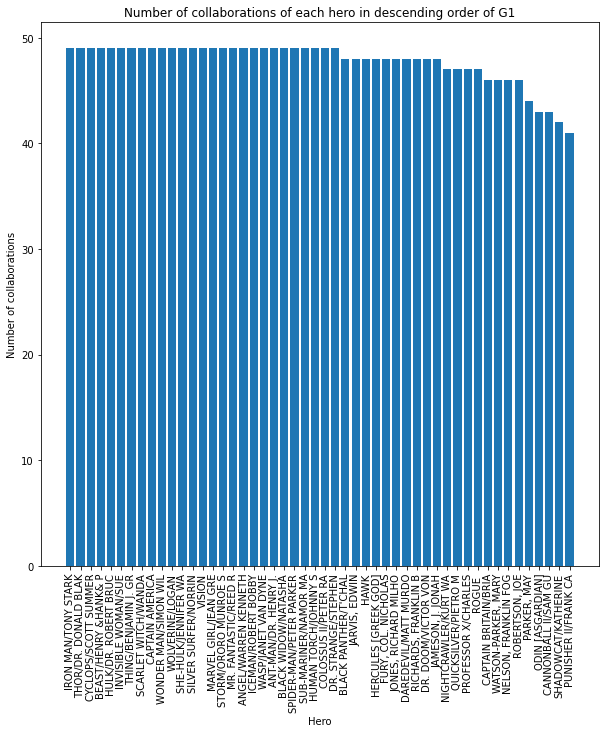

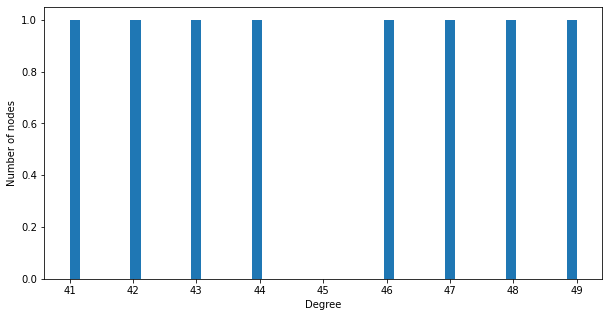

In [80]:
controller_system()

The sorted collaborations of each node shows the number of collaborations 
that each character has with other characters in the network. 

The density of G1 is 0.974, which means that there is a high level of connection among the characters in the network. 
 
The average degree of G1 is 47.76, which is a measure of the number of 
connections per character in the network. 

The type of G1 is "DENSE", which means that there are a high number of 
connections in the network. 

The "hubs table" of G1 is empty, which means that there are no characters 
in the network that have a significantly higher number of connections than the other characters.

You have chosen functionality 1 which extract the graph's features.
You have chosen to analyze the graph of type 2.
You have chosen to consider the top 50 heroes.
General info of G2:
   Number of hero nodes  Number of comic nodes    Density  Average degree  \
0                    50                   9236  22.623673        5.968986   

  Netowrk type  
0       SPARSE  
Plot of the hubs table of G2:
       Hubs
0     COC 1
1    H2 279
2    M/GN 1
3      IW 2
4      IW 3
..      ...
319  ROM 23
320   XU 25
321   UX 12
322  HR:R 2
323  FF 244

[324 rows x 1 columns]


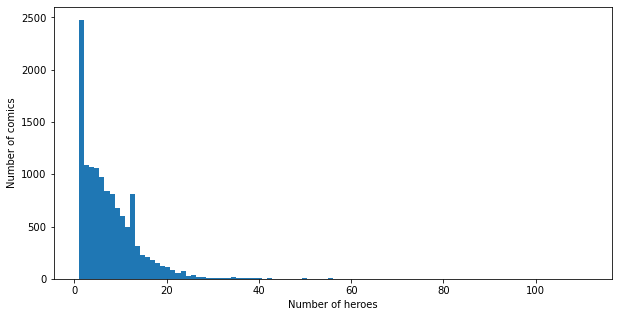

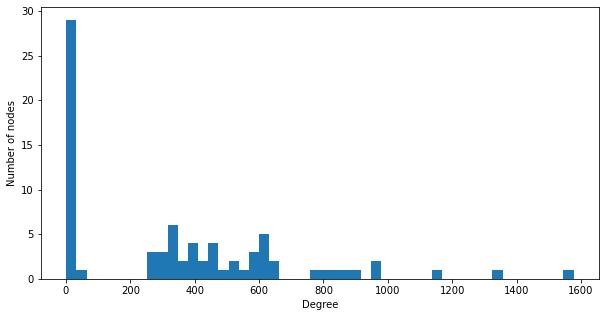

In [81]:
controller_system()

The "the number of heroes that have appeared in each comic" table shows the number of heroes that have appeared in each comic book. 

The density of G2 is 22.62, which means that there is a high level of connection among the comic books in the network. 

The average degree of G2 is 5.97, which is a measure of the number of connections per comic book in the network. 
 
There are 324 nodes with degrees more extensive than the 95th percentile of the degree distribution, which means that these comic books have more connections (heroes appearing in them) than the majority of the other comic books in the network.

From the first plot we can see the number of heres that appeared in each comic and that the most comics have 1 hero, around 1000 comics have 2 heroes. From the second plot we can see the degree distribution of the graph and that the most nodes have degree 1.

## Controller System - Functionality 2

In [97]:
controller_system()

You have chosen to analyze the node CAPTAIN AMERICA.
You have chosen to consider the top 50 heroes.
You have chosen to use the metric betweenness.
                         betweenness
BLACK WIDOW/NATASHA         0.000635
SILVER SURFER/NORRIN        0.000635
HUMAN TORCH/JOHNNY S        0.000635
COLOSSUS II/PETER RA        0.000635
IRON MAN/TONY STARK         0.000635
ANT-MAN/DR. HENRY J.        0.000635
WASP/JANET VAN DYNE         0.000635
DR. STRANGE/STEPHEN         0.000635
ICEMAN/ROBERT BOBBY         0.000635
ANGEL/WARREN KENNETH        0.000635
MR. FANTASTIC/REED R        0.000635
STORM/ORORO MUNROE S        0.000635
MARVEL GIRL/JEAN GRE        0.000635
SPIDER-MAN/PETER PARKER     0.000635
VISION                      0.000635
SHE-HULK/JENNIFER WA        0.000635
INVISIBLE WOMAN/SUE         0.000635
THOR/DR. DONALD BLAK        0.000635
CYCLOPS/SCOTT SUMMER        0.000635
WOLVERINE/LOGAN             0.000635
HULK/DR. ROBERT BRUC        0.000635
BEAST/HENRY &HANK& P        0.000635
TH

The highest are have 0.000635, so the node "CAPTAIN AMERICA" is not very important in the network, then we see "PUNISHER II/FRANK CA" with 0.000199 "SHADOWCAT/KATHERINE" with 0.000078, have an higher value means that node is important in the network and that node is the only bridge connection between
two other nodes, a lot of nodes have the same betweenness centrality, so we can say that a lot of nodes have a privileged position in the network.

In [98]:
controller_system()

You have chosen to analyze the node CAPTAIN AMERICA.
You have chosen to consider the top 50 heroes.
You have chosen to use the metric degree.
                           degree
BLACK WIDOW/NATASHA      1.000000
SILVER SURFER/NORRIN     1.000000
HUMAN TORCH/JOHNNY S     1.000000
COLOSSUS II/PETER RA     1.000000
IRON MAN/TONY STARK      1.000000
ANT-MAN/DR. HENRY J.     1.000000
WASP/JANET VAN DYNE      1.000000
DR. STRANGE/STEPHEN      1.000000
ICEMAN/ROBERT BOBBY      1.000000
ANGEL/WARREN KENNETH     1.000000
MR. FANTASTIC/REED R     1.000000
STORM/ORORO MUNROE S     1.000000
MARVEL GIRL/JEAN GRE     1.000000
SPIDER-MAN/PETER PARKER  1.000000
VISION                   1.000000
SHE-HULK/JENNIFER WA     1.000000
INVISIBLE WOMAN/SUE      1.000000
THOR/DR. DONALD BLAK     1.000000
CYCLOPS/SCOTT SUMMER     1.000000
BEAST/HENRY &HANK& P     1.000000
WOLVERINE/LOGAN          1.000000
HULK/DR. ROBERT BRUC     1.000000
THING/BENJAMIN J. GR     1.000000
SCARLET WITCH/WANDA      1.000000
CAPTAIN 

 The difference here it's that in this case we have a lot of nodes with 
 degree of one, so we can say that a lot of nodes have a privileged position 
 in the network.


In [102]:
controller_system()

You have chosen to analyze the node CAPTAIN AMERICA.
You have chosen to consider the top 50 heroes.
You have chosen to use the metric pagerank.
                         pagerank
NELSON, FRANKLIN FOG     0.045964
CAPTAIN BRITAIN/BRIA     0.044375
PUNISHER II/FRANK CA     0.044043
ODIN [ASGARDIAN]         0.043782
WATSON-PARKER, MARY      0.043297
PARKER, MAY              0.041889
ROBERTSON, JOE           0.038686
JONES, RICHARD MILHO     0.031896
CANNONBALL II/SAM GU     0.031665
JAMESON, J. JONAH        0.025172
SILVER SURFER/NORRIN     0.024864
RICHARDS, FRANKLIN B     0.023526
NIGHTCRAWLER/KURT WA     0.023499
ROGUE                    0.020498
BLACK PANTHER/T'CHAL     0.020324
WONDER MAN/SIMON WIL     0.019390
DR. DOOM/VICTOR VON      0.019299
JARVIS, EDWIN            0.018236
COLOSSUS II/PETER RA     0.018010
SUB-MARINER/NAMOR MA     0.017969
HERCULES [GREEK GOD]     0.017932
FURY, COL. NICHOLAS      0.017700
SHADOWCAT/KATHERINE      0.017601
ICEMAN/ROBERT BOBBY      0.017419
MARVEL

 In thus case we don't have values very high, so we can say that some are 
 more important than others, but not that much as the previous case.

In [106]:
controller_system()

You have chosen to analyze the node CAPTAIN AMERICA.
You have chosen to consider the top 50 heroes.
You have chosen to use the metric closeness.
                         closeness
BLACK WIDOW/NATASHA       1.000000
SILVER SURFER/NORRIN      1.000000
HUMAN TORCH/JOHNNY S      1.000000
COLOSSUS II/PETER RA      1.000000
IRON MAN/TONY STARK       1.000000
ANT-MAN/DR. HENRY J.      1.000000
WASP/JANET VAN DYNE       1.000000
DR. STRANGE/STEPHEN       1.000000
ICEMAN/ROBERT BOBBY       1.000000
ANGEL/WARREN KENNETH      1.000000
MR. FANTASTIC/REED R      1.000000
STORM/ORORO MUNROE S      1.000000
MARVEL GIRL/JEAN GRE      1.000000
SPIDER-MAN/PETER PARKER   1.000000
VISION                    1.000000
SHE-HULK/JENNIFER WA      1.000000
INVISIBLE WOMAN/SUE       1.000000
THOR/DR. DONALD BLAK      1.000000
CYCLOPS/SCOTT SUMMER      1.000000
BEAST/HENRY &HANK& P      1.000000
WOLVERINE/LOGAN           1.000000
HULK/DR. ROBERT BRUC      1.000000
THING/BENJAMIN J. GR      1.000000
SCARLET WITCH/W

Most of the nodes have a centrality of 1.0, which means that they are easily 
reachable from all other nodes in the graph.

There are some nodes, however, such as BLACK PANTHER/T'CHAL, JARVIS, EDWIN, 
HAWK, and HERCULES [GREEK GOD], that have slightly lower proximity.

 Looking at the results obtained betweenness centrality, PageRank centrality 
 and degree centrality are all based on the structure of the graph and try 
 to measure how important a node is in the interconnection of the graph.

 For example, a node with high betweenness centrality could be a stepping node 
 for many paths within the graph, while a node with high PageRank centrality 
 could be considered important if it has been connected by many other 
 important nodes.

 On the other hand, closeness-centrality is based on the distance of a node 
 from all other nodes in the graph. A node with high closeness centrality 
 is usually considered important because it is close to other important nodes.

##  Controller System - Functionality 3

Select your functionality (from 1 to 5): 3
You have chosen functionality 3 which computes the shortest path of comics between two given heros.
Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: 3
You have chosen to consider the top 3 heroes.
Insert the hero from which the path should start: SPIDER-MAN/PETER PARKER
The hero from which the path will start is: SPIDER-MAN/PETER PARKER
Insert the hero in which the path should end: CAPTAIN AMERICA
The hero in which the path will end is: CAPTAIN AMERICA
Insert the number of heros that you want to visit during the path: 1
Insert the 1 -th hero:
IRON MAN/TONY STARK
During the path you have chosen to visit the following heros: ['IRON MAN/TONY STARK']
 
This is the shortest path including all the nodes (heros and comics) that have been visited:
['SPIDER-MAN/PETER PARKER' 'A 11' 'IRON MAN/TONY STARK' "A '00"
 'CAPTAIN AMERICA']
 
This is the shortest path of comics in order starting from the hero SPIDE

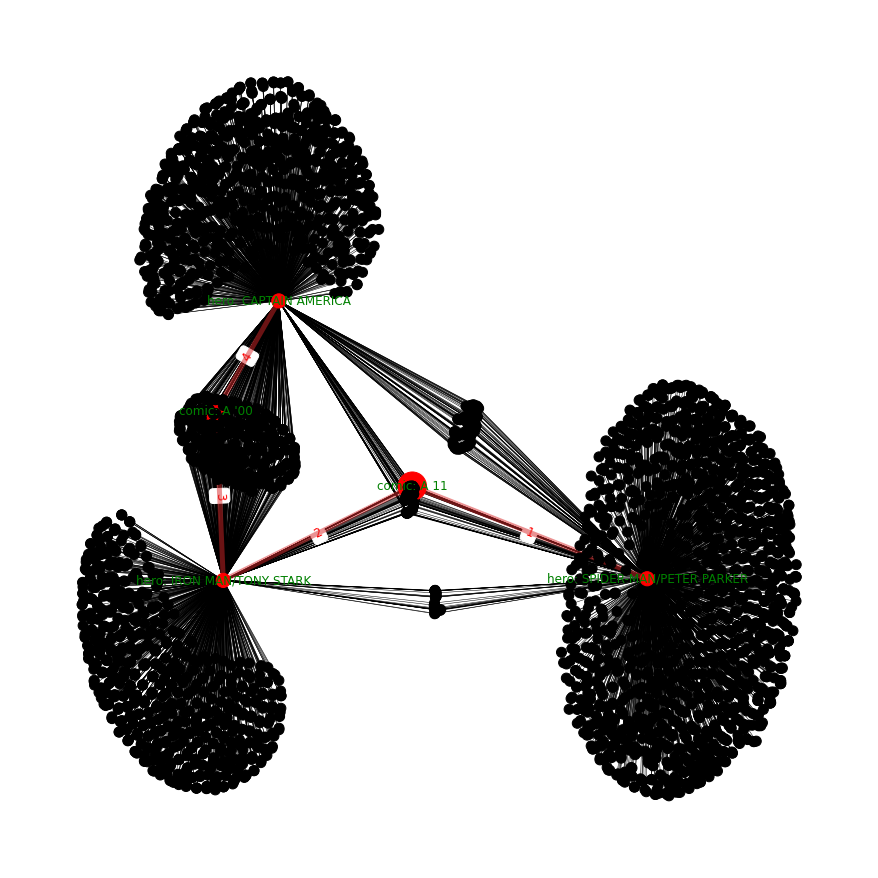

Since the graph above contains a lot of nodes the following plot contains only the nodes of the shortest path.


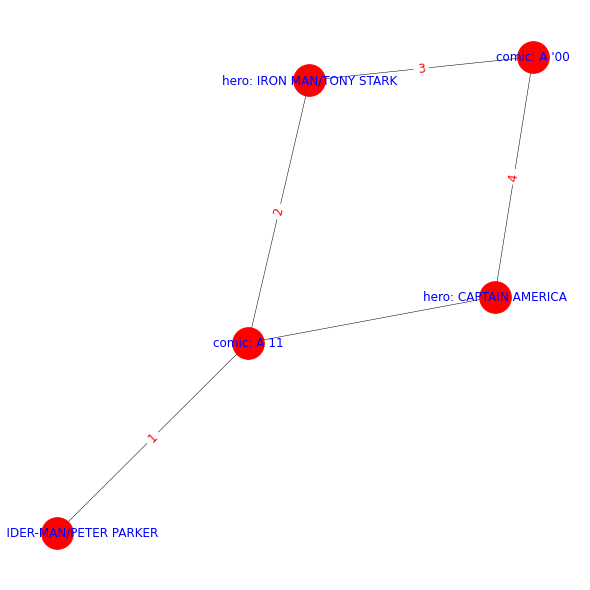

In [46]:
controller_system()

##  Controller System - Functionality 4

You have chosen functionality 4 which disconnects the original graph G1 into two disconnected subgraphs: G_a and G_b.
You have chosen to consider the top 15 heroes.
['IRON MAN/TONY STARK', 'THOR/DR. DONALD BLAK', 'BEAST/HENRY &HANK& P', 'HULK/DR. ROBERT BRUC', 'INVISIBLE WOMAN/SUE', 'THING/BENJAMIN J. GR', 'SCARLET WITCH/WANDA', 'CAPTAIN AMERICA', 'WOLVERINE/LOGAN', 'MR. FANTASTIC/REED R', 'WATSON-PARKER, MARY', 'SPIDER-MAN/PETER PARKER', 'DAREDEVIL/MATT MURDO', 'HUMAN TORCH/JOHNNY S', 'DR. STRANGE/STEPHEN']
The hero which creates G_a is IRON MAN/TONY STARK
The hero which creates G_b is SPIDER-MAN/PETER PARKER
 
The minimum number of links required to disconnect the original graph into two disconnected subgraphs is: 36
Plot of the original graph: 


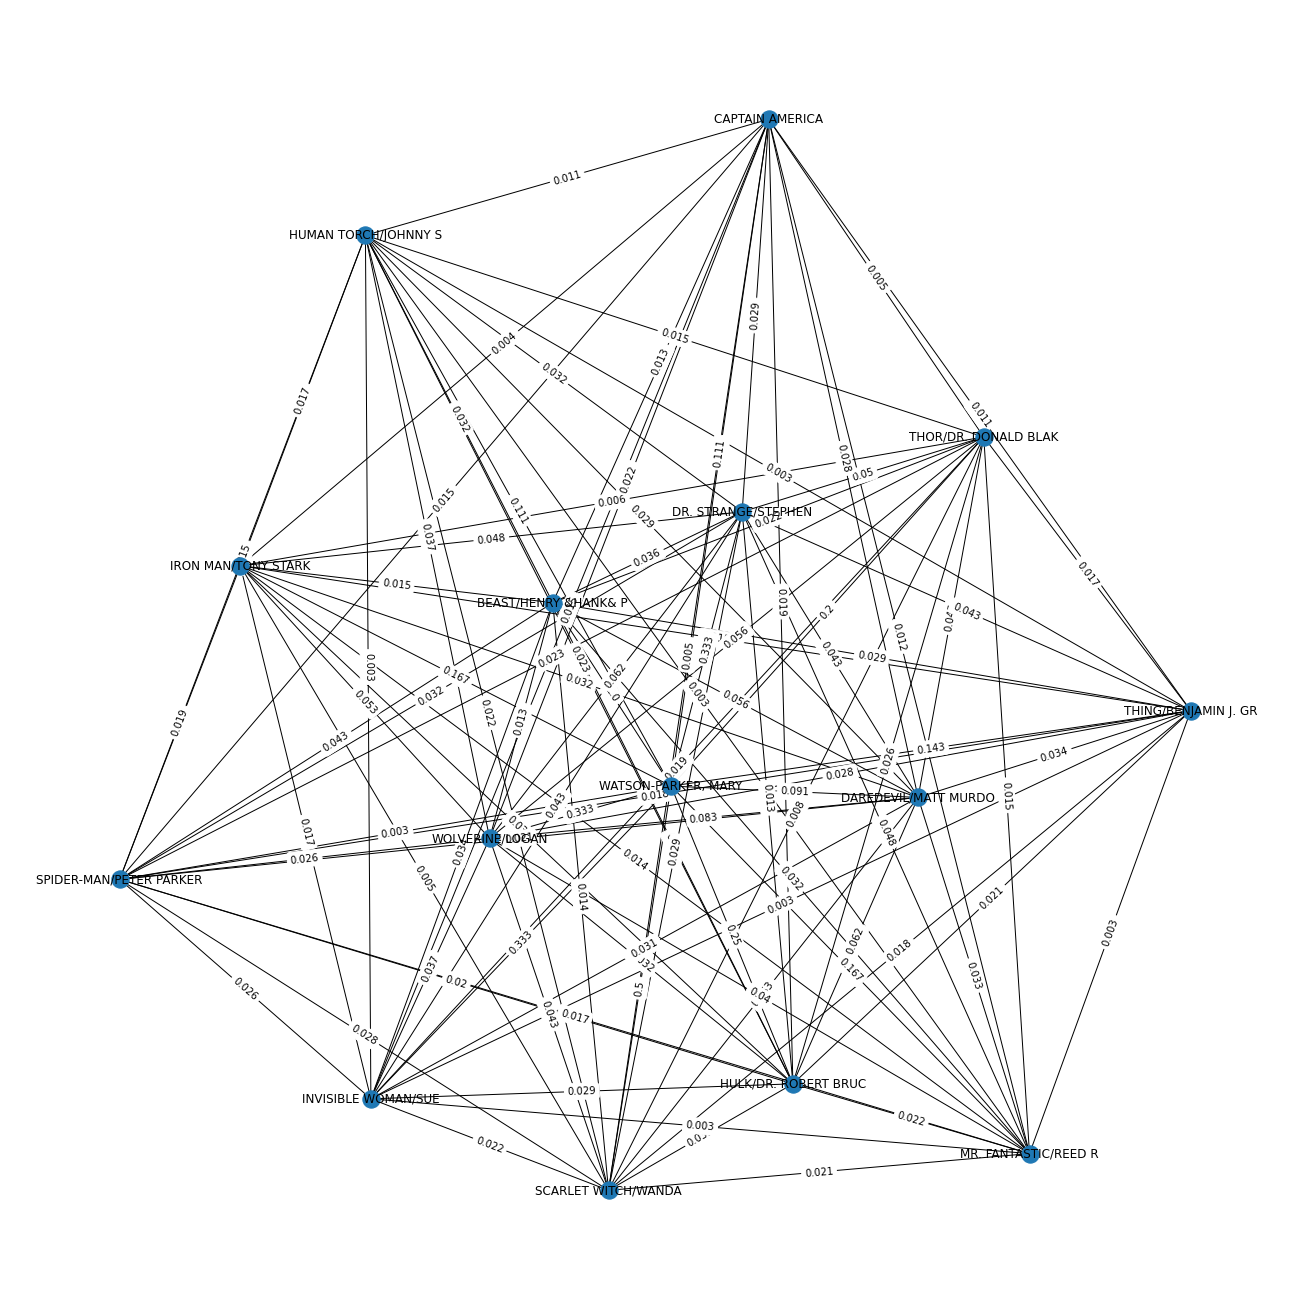

Plot of the graph after removing the links and identify the two nodes: 


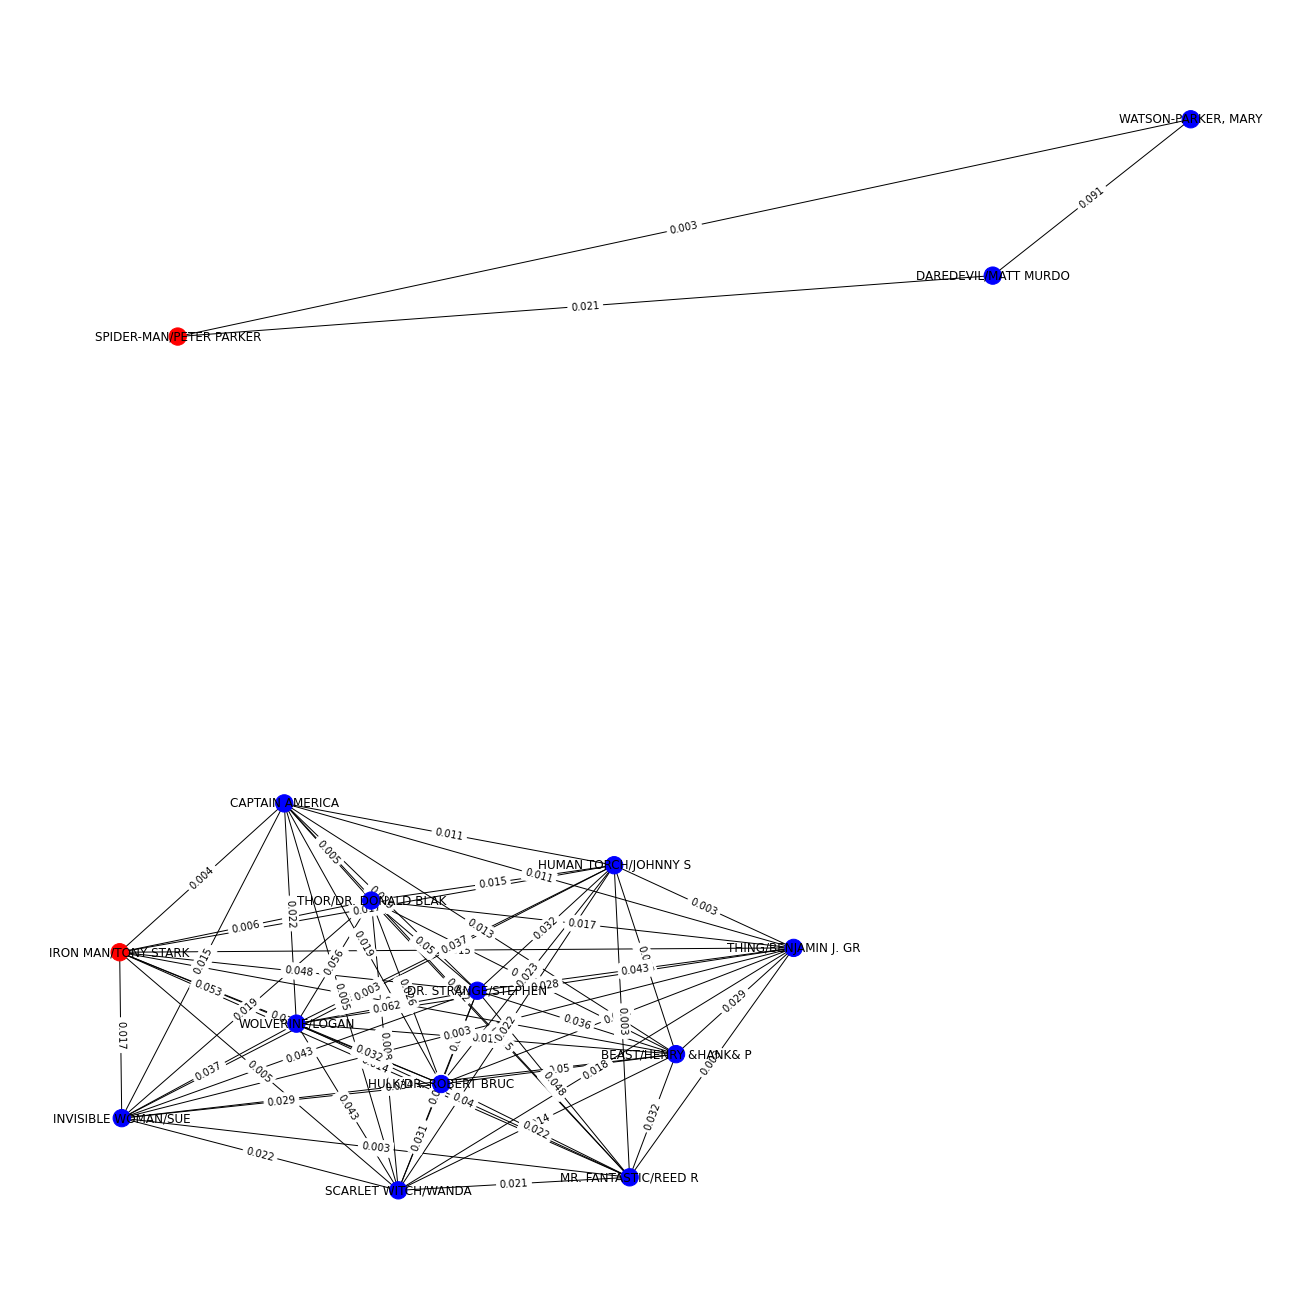

In [57]:
controller_system()

## Controller System - Functionality 5

Select your functionality (from 1 to 5): 5
You have chosen functionality 5 which it will be computed the minimum number of edges that should be removed to form communities in the first graph.
Insert the number of top heroes you want to consider or 0 if you want to consider the all graph: 50
You have chosen to consider the top 50 heroes.
 
The number of links that should be removed to have the communities is:  42
 
The components of the 1 -th comunity are:
['THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE', 'IRON MAN/TONY STARK', 'WONDER MAN/SIMON WIL', 'MR. FANTASTIC/REED R', 'CANNONBALL II/SAM GU', 'NELSON, FRANKLIN FOG', 'STORM/ORORO MUNROE S', 'HERCULES [GREEK GOD]', 'NIGHTCRAWLER/KURT WA', 'SHADOWCAT/KATHERINE', 'BEAST/HENRY &HANK& P', 'JARVIS, EDWIN', 'PROFESSOR X/CHARLES', 'SHE-HULK/JENNIFER WA', 'CAPTAIN AMERICA', 'CYCLOPS/SCOTT SUMMER', 'VISION', 'ROGUE ', 'SPIDER-MAN/PETER PARKER', 'PARKER, MAY', "BLACK PANTHER/T'CHAL", 'ANGEL/WARREN KENNETH', 'DR. DOOM/VICTOR VON', 'HAWK', 'THOR/

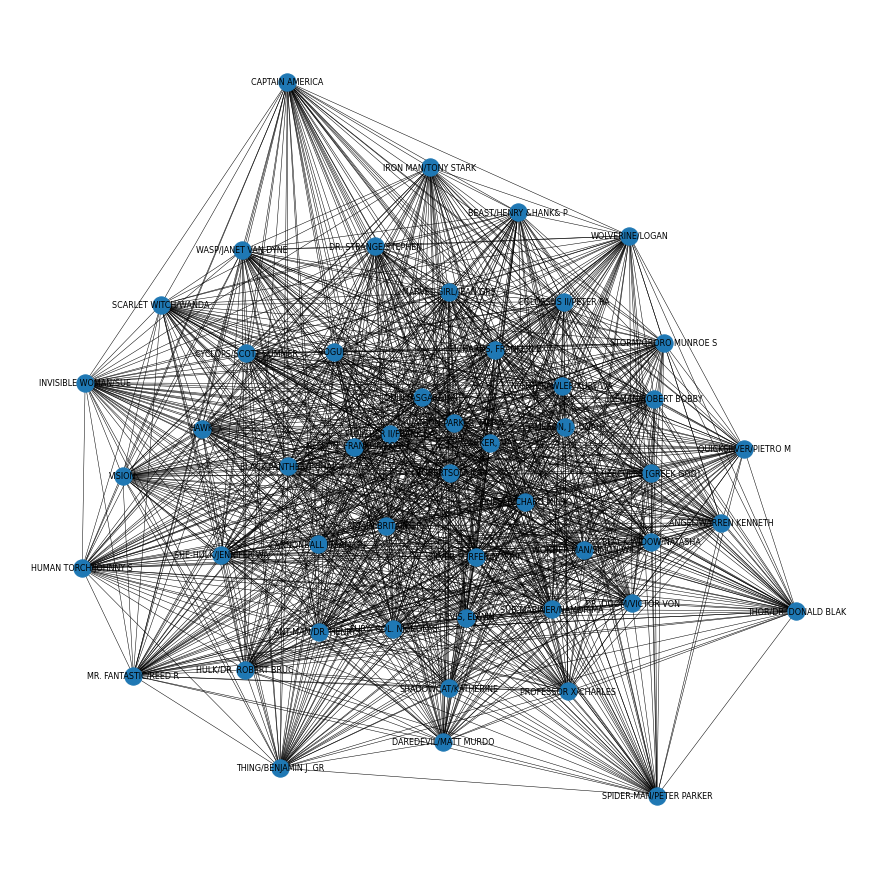

The final graph divided in comunities, all of them in different colors, is:


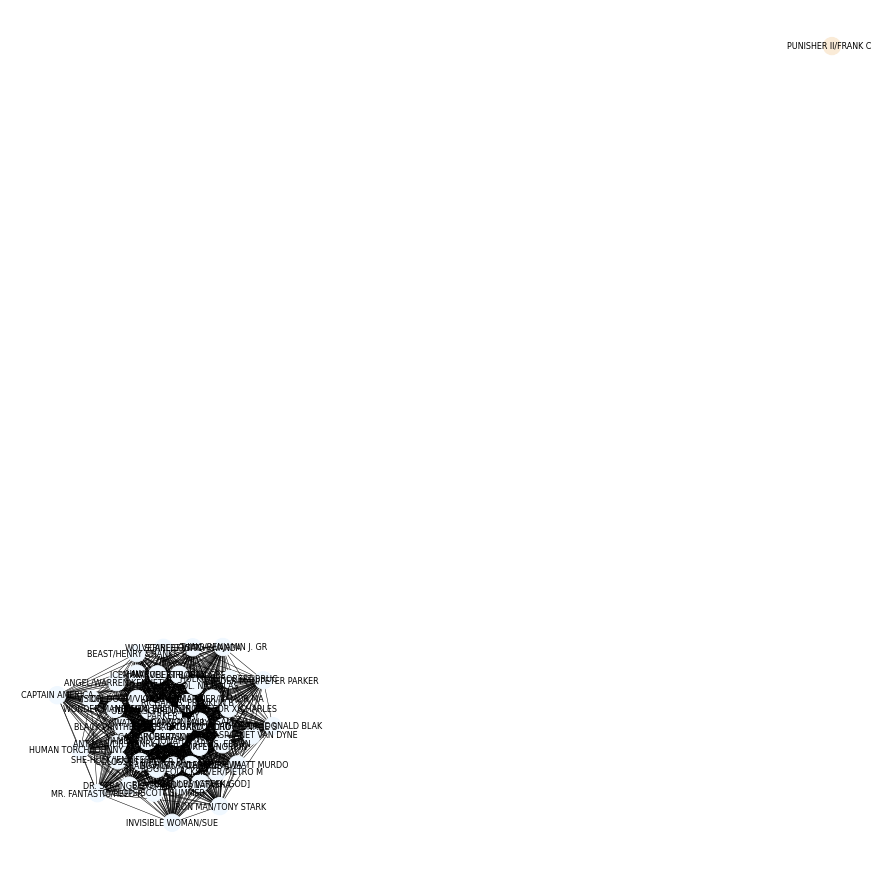

CAPTAIN AMERICA and IRON MAN/TONY STARK are in the same comunity


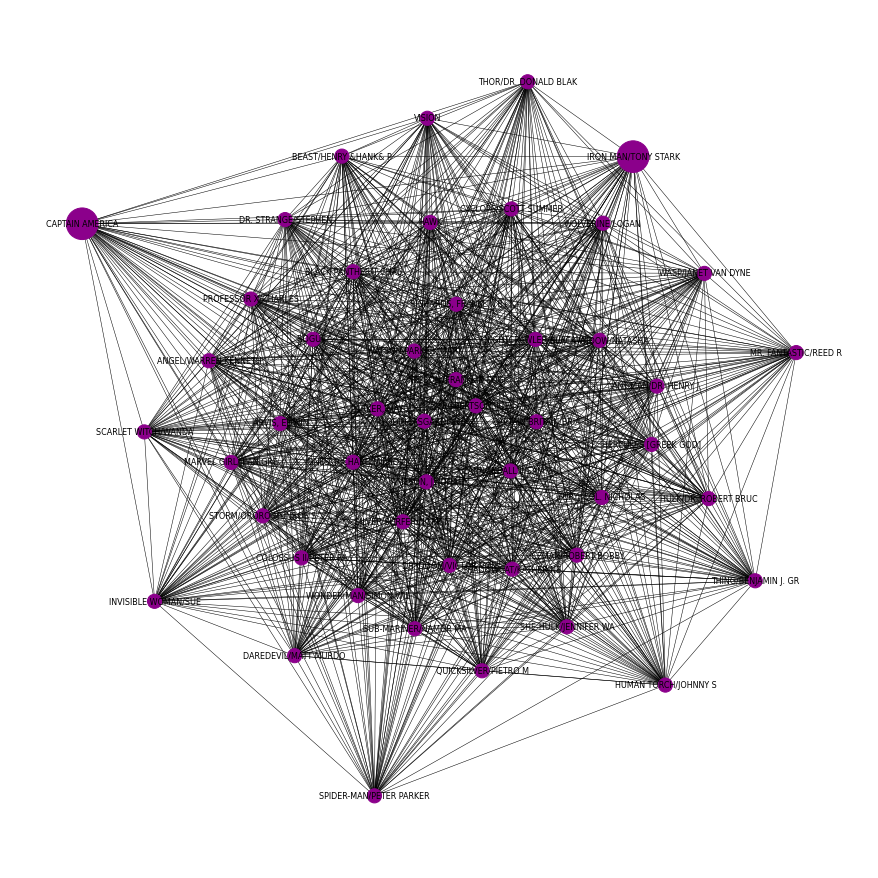

In [52]:
controller_system()

# Algorithmic Question

In [1]:
def paths(r,c,visited,directions,app_count):
    if directions == []:
        app_count+=1
        return app_count
    for k in range(len(directions)):
        if directions[k] == 'R' and c == 0:
            c += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count
            c+=1
            if [r,c] not in visited and [r,c-1] not in visited:
                visited.append([r,c-1])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c-1])
                visited.remove([r,c])
        if directions[k] == 'R' and c == 1:
            c += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])

        if directions[k] == 'U' and r == 2:
            r -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count
            r -= 1
            if [r,c] not in visited and [r-1,c] not in visited:
                visited.append([r-1,c])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r-1,c])
                visited.remove([r,c])
        if directions[k] == 'U' and r == 1:
            r -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
                
        if directions[k] == 'D' and r == 0:
            r += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count

            r += 1
            if [r,c] not in visited and [r-1,c] not in visited:
                visited.append([r-1,c])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r-1,c])
                visited.remove([r,c])
        if directions[k] == 'D' and r == 1:
            r += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
        
        if directions[k] == 'L' and c == 2:
            c -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            c -= 1
            if [r,c] not in visited and [r,c+1] not in visited:
                visited.append([r,c+1])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c+1])
                visited.remove([r,c])
        if directions[k] == 'L' and c == 1:
            c -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
        else:
            return app_count
         
        return app_count

In [2]:
def find_number_patterns(directions):
    directions = list(directions)
    count=0
    for r in range(3):
        for c in range(3):
            visited = [[r,c]]
            app_count=0
            app_count = paths(r,c,visited,directions,app_count)
            count += app_count
    return count

Test the algorithm with different inputs

In [80]:
find_number_patterns("DRU")

15

In [81]:
find_number_patterns("R")

9

In [82]:
find_number_patterns("LDRDRUL")

0

In [6]:
find_number_patterns("RDLU")

9